Multi-level Perturbed Unit Gradient Descent, MPUGD

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
from torch.utils.data  import Subset, DataLoader

import torchvision
import torchvision.transforms as transforms
from types import SimpleNamespace 
import matplotlib.pyplot  as plt
import numpy as np 

from optimizers import *
from upanets import UPANets
from torchsummary import summary
import time, copy,timm
import json
import random 
import os
from train import *

d:\Python\python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
args = SimpleNamespace(
    datasets='cifar_100',
    batch_size = 500,
    seed = 42,
    lr=0.1, 
    momentum=0.9,
    wd = 0.0005,
    blocks = 1,
    filters = 16,
    epochs = 400,
    start_epochs = 8
    )

In [3]:
def set_all_seeds(seed=42):
    # Python原生随机 
    random.seed(seed) 
    # NumPy随机 
    np.random.seed(seed) 
    # PyTorch随机 
    torch.manual_seed(seed) 
    # CUDA随机（GPU相关）
    torch.cuda.manual_seed_all(seed) 
    # CUDNN确定性模式 
    torch.backends.cudnn.deterministic  = True 
    torch.backends.cudnn.benchmark  = False 
 
set_all_seeds(args.seed)  

In [4]:
print(device)

cuda


In [5]:
img_size = 32 # default image size for Cifar-10
im_dimention = 32
cifar_10_mean = [0.4914, 0.4822, 0.4465] 
cifar_10_std = [0.2023, 0.1994, 0.2010]
cifar_100_mean = [0.5071, 0.4867, 0.4408]
cifar_100_std = [0.2673, 0.2564, 0.2762]

if args.datasets == 'cifar_10':
    data_transforms = {
        'train': transforms.Compose([
            transforms.Resize((im_dimention,im_dimention)),
            transforms.RandomRotation(15,),
            transforms.RandomCrop(im_dimention),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(mean=cifar_10_mean, std=cifar_10_std)
            # transforms.Lambda(lambda x: x.to(torch.float16))    # 最终输出FP16
        ]),
        # 'valid': transforms.Compose([
        #     transforms.Resize((im_dimention,im_dimention)),
        #     transforms.ToTensor(),
        #     transforms.Normalize(mean=cifar_10_mean, std=cifar_10_std)
        # ]),
        'test': transforms.Compose([
            transforms.Resize((im_dimention,im_dimention)),
            transforms.ToTensor(),
            transforms.Normalize(mean=cifar_10_mean, std=cifar_10_std)
        ]),
    }
 
    full_trainset = torchvision.datasets.CIFAR10(
        root='./data/cifar_10', train=True, download=True, transform=data_transforms['train'])
    testset = torchvision.datasets.CIFAR10(
        root='./data/cifar_10', train=False, download=True, transform=data_transforms['test'])
    testloader = torch.utils.data.DataLoader(
        testset, batch_size=args.batch_size, shuffle=False, num_workers=0)
    Num_class = 10

if args.datasets == 'cifar_100':
    data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((im_dimention,im_dimention)),
        transforms.RandomRotation(15,),
        transforms.RandomCrop(im_dimention),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=cifar_100_mean, std=cifar_100_std)
    ]),
    # 'valid': transforms.Compose([
    #     transforms.Resize((im_dimention,im_dimention)),
    #     transforms.ToTensor(),
    #     transforms.Normalize(mean=cifar_100_mean, std=cifar_100_std)
    # ]),
    'test': transforms.Compose([
        transforms.Resize((im_dimention,im_dimention)),
        transforms.ToTensor(),
        transforms.Normalize(mean=cifar_100_mean, std=cifar_100_std)
    ]),
    }
    full_trainset = torchvision.datasets.CIFAR100(
        root='./data/cifar_100', train=True, download=True, transform=data_transforms['train'])
    testset = torchvision.datasets.CIFAR100(
        root='./data/cifar_100', train=False, download=True, transform=data_transforms['test'])
    testloader = DataLoader(
        testset, batch_size=args.batch_size, shuffle=False,sampler=torch.utils.data.SequentialSampler(testset),  num_workers=0)
    Num_class = 100

# # 获取所有样本的标签 
# labels = [full_trainset[i][1] for i in range(len(full_trainset))]

# # 分层划分（stratify参数确保比例）
# train_idx, val_idx = train_test_split(
#     range(len(full_trainset)),
#     test_size=0.2,
#     shuffle=True,
#     stratify=labels,
#     random_state=args.seed  
# )

# train_data = np.stack([full_trainset.data[i]  for i in train_idx]) 
# train_targets = [full_trainset.targets[i] for i in train_idx] 
# val_data = np.stack([full_trainset.data[i]  for i in val_idx]) 
# val_targets = [full_trainset.targets[i] for i in val_idx] 

# valset = full_trainset
# valset.data = val_data
# valset.targets = val_targets
# valset.transform = data_transforms['valid']

# trainset = copy.deepcopy(valset)
# trainset.data = train_data
# trainset.targets = train_targets
# trainset.transform = data_transforms['train']

# trainloader = {
#     'train':DataLoader(
#     trainset, batch_size=args.batch_size, shuffle=False, sampler=torch.utils.data.SequentialSampler(trainset), num_workers=0),
#     'valid':DataLoader(
#     valset, batch_size=args.batch_size, shuffle=False, sampler=torch.utils.data.SequentialSampler(valset), num_workers=0)}

# dataset_sizes = {
#     'train': len(trainset),
#     'valid': len(valset),            
                #  }

trainloader = {
    'train':DataLoader(
    full_trainset, batch_size=args.batch_size, shuffle=False, sampler=torch.utils.data.SequentialSampler(full_trainset), num_workers=0),
    'valid':testloader
}

dataset_sizes = {
    'train': len(full_trainset),
    'valid': len(testset),      
}
print(dataset_sizes)


100%|██████████| 169M/169M [00:44<00:00, 3.83MB/s] 


{'train': 50000, 'valid': 10000}


In [6]:
print(timm.list_models('*vit_tiny_patch16_224*')) 

['vit_tiny_patch16_224']


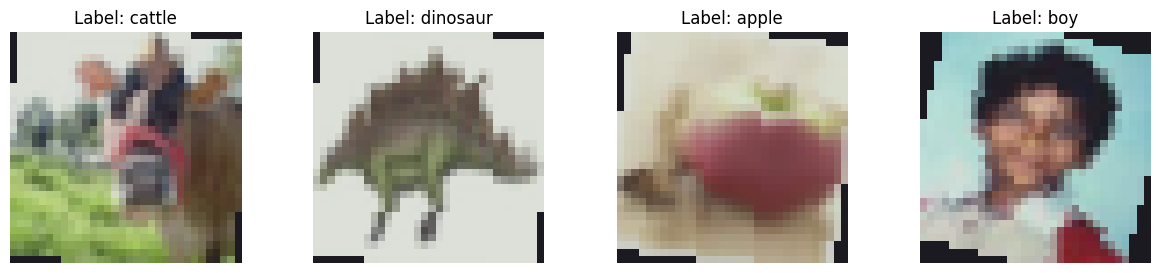

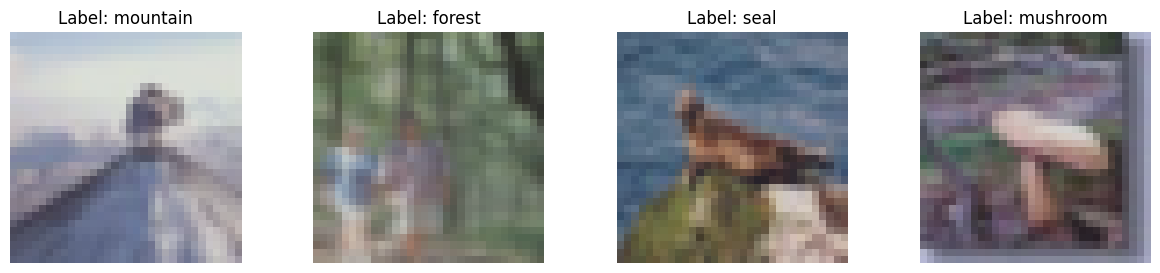

In [7]:
# from torchvision.transforms.functional  import to_pil_image 
# 反归一化转换（需与transform中的参数对应）
inv_normalize = transforms.Normalize(
    mean=[-0.4914/0.2023, -0.4822/0.1994, -0.4465/0.2010],
    std=[1/0.2023, 1/0.1994, 1/0.2010]
)
 
def show_images(loader, num_images=4):
    # 获取一个batch的数据 
    # images, labels = next(iter(loader))
    for batch_idx, (images, labels) in enumerate(loader):
        if batch_idx == 0:  # 只取第一个batch 
            break 

    # 创建子图 
    fig, axes = plt.subplots(1,  num_images, figsize=(15, 3))
    
    for i in range(num_images):
        # 反归一化+通道顺序调整 
        img = inv_normalize(images[i]).permute(1, 2, 0).numpy()
        img = np.clip(img,  0, 1)  # 处理浮点误差 
        
        # 显示图像及标签 
        axes[i].imshow(img)
        axes[i].set_title(f"Label: {full_trainset.classes[labels[i]]}") 
        axes[i].axis('off')
    
    plt.show() 
 
show_images(trainloader['train'])
show_images(testloader)

In [8]:
model_path = "./model/" + args.datasets + "/benckmark.pth"
if os.path.exists(model_path):
    net_benckmark_data = torch.load(model_path,  map_location='cpu')
    benckmark_state_dict = net_benckmark_data['model_state_dict'] 
else:
    net_benchmark = UPANets(args.filters, Num_class, args.blocks, img_size)
    torch.save({
        'model_state_dict': net_benchmark.state_dict()
    }, model_path)
    benckmark_state_dict = net_benchmark.state_dict()

def tensor_to_serializable(obj):
    if isinstance(obj, (np.float32,  np.float64)):   # 处理NumPy浮点数
        return float(obj)
    elif isinstance(obj, np.integer):               # 处理NumPy整数 
        return int(obj)
    elif isinstance(obj, torch.Tensor):            # 处理PyTorch Tensor 
        return obj.item()  if obj.numel()  == 1 else obj.tolist() 
    elif isinstance(obj, (np.ndarray)):             # 处理NumPy数组 
        return obj.tolist() 
    elif hasattr(obj, '__dict__'):                 # 处理自定义对象（可选）
        return obj.__dict__
    return obj 


In [9]:
# net_pugdt_delta = UPANets(args.filters, Num_class, args.blocks, img_size)  
# net_pugdt_delta.load_state_dict(copy.deepcopy(benckmark_state_dict))
# criterion = torch.nn.CrossEntropyLoss()

# net_pugdt_delta.to(device)

# if device == 'cuda' and torch.cuda.device_count() > 1:
#     net_pugdt_delta = torch.nn.DataParallel(net_pugdt_delta)
#     cudnn.benchmark = True

# base_optimizer = optim.SGD
# optimizer = PUGDXT(net_pugdt_delta.parameters(),
#                 base_optimizer,
#                 lr=args.lr,
#                 momentum=args.momentum,
#                 weight_decay=args.wd,
#                 dampening=0,   # 必须设置为0才能完全固定 
#                 nesterov=False # 禁用Nesterov动量 
#                 )

# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=args.epochs)

# net_pugdt_delta, metricst_delta = train_model_timing_delta(net_pugdt_delta, criterion, optimizer, scheduler, args.epochs, trainloader, device, dataset_sizes, int(args.epochs/10), 0.01, 10) 

# model_path = "./model/"+args.datasets+"/pugdt_delta_" + str(args.epochs) + "xi" + str(args.epochs/10) + "mu0.01_t10.pth"
# torch.save({
#     'model_state_dict': net_pugdt_delta.state_dict(), 
#     'optimizer_state_dict': optimizer.state_dict()
# }, model_path) 

# name = "./results/"+args.datasets+"/pugdt_delta_" + str(args.epochs) + "xi" + str(args.epochs/10) + "mu0.01_t10.json"
# with open(name,  'w', encoding='utf-8') as f:
#     json.dump(metricst_delta,  f, default=tensor_to_serializable, ensure_ascii=False, indent=4)


In [10]:
# net_pugdt_var = UPANets(args.filters, Num_class, args.blocks, img_size)  
# net_pugdt_var.load_state_dict(copy.deepcopy(benckmark_state_dict))
# criterion = torch.nn.CrossEntropyLoss()

# net_pugdt_var.to(device)

# if device == 'cuda' and torch.cuda.device_count() > 1:
#     net_pugdt_var = torch.nn.DataParallel(net_pugdt_var)
#     cudnn.benchmark = True

# base_optimizer = optim.SGD
# optimizer = PUGDXT(net_pugdt_var.parameters(),
#                 base_optimizer,
#                 lr=args.lr,
#                 momentum=args.momentum,
#                 weight_decay=args.wd,
#                 dampening=0,   # 必须设置为0才能完全固定 
#                 nesterov=False # 禁用Nesterov动量 
#                 )

# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=args.epochs)

# net_pugdt_var, metricst_var = train_model_timing_var(net_pugdt_var, criterion, optimizer, scheduler, args.epochs, trainloader, device, dataset_sizes, int(args.epochs/10), 0.015, 10) 

# model_path = "./model/"+args.datasets+"/pugdt_var_" + str(args.epochs) + "init_t" + str(args.epochs/10) + "gamma0.015_k10.pth"
# torch.save({
#     'model_state_dict': net_pugdt_var.state_dict(), 
#     'optimizer_state_dict': optimizer.state_dict()
# }, model_path) 

# name = "./results/"+args.datasets+"/pugdt_var_" + str(args.epochs) + "init_t" + str(args.epochs/10) + "gamma0.015_k10.json"
# with open(name,  'w', encoding='utf-8') as f:
#     json.dump(metricst_var,  f, default=tensor_to_serializable, ensure_ascii=False, indent=4)


In [11]:
net = UPANets(args.filters, Num_class, args.blocks, img_size)
net.load_state_dict(copy.deepcopy(benckmark_state_dict))

criterion = torch.nn.CrossEntropyLoss()

net.to(device)

if device == 'cuda' and torch.cuda.device_count() > 1:
    net = torch.nn.DataParallel(net)
    cudnn.benchmark = True

optimizer = optim.SGD(net.parameters(),
                lr=args.lr,
                momentum=args.momentum,
                weight_decay=args.wd,
                dampening=0,   # 必须设置为0才能完全固定 
                nesterov=False # 禁用Nesterov动量 
                 )

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=args.epochs)
# Decay LR by a factor of 0.1 every 7 epochs
# exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

net, metrics_org = train_model_org(net, criterion, optimizer, scheduler, args.epochs * 2, trainloader, device, dataset_sizes) 

# 保存模型架构+参数+优化器状态（完整恢复训练）
model_path = "./model/"+args.datasets+"/org" + str(args.epochs) + ".pth"
torch.save({
    'model_state_dict': net.state_dict(), 
    'optimizer_state_dict': optimizer.state_dict()
}, model_path) 

name = "./results/"+args.datasets+"/org_" + str(args.epochs) + ".json"
with open(name,  'w', encoding='utf-8') as f:
    json.dump(metrics_org, f, default=tensor_to_serializable, ensure_ascii=False, indent=4)
 
# 加载 

# checkpoint = torch.load('full_model_checkpoint.pth',  map_location='cpu')  # 先加载到CPU避免设备冲突 
# 模型结构需提前定义（需与保存时一致）
# model = YourModelClass()  
# model.load_state_dict(checkpoint['model_state_dict']) 
 
# # 恢复优化器和训练状态 
# optimizer = torch.optim.Adam(model.parameters())  
# optimizer.load_state_dict(checkpoint['optimizer_state_dict']) 
# with open('data.json',  'r', encoding='utf-8') as f:
#     loaded_dict = json.load(f) 


# summary(net, (3, img_size, img_size))


Epoch 0/799
23.796066999435425
Epoch 1/799
23.226914405822754
Epoch 2/799
23.32538676261902
Epoch 3/799
23.306834936141968
Epoch 4/799
23.467599630355835
Epoch 5/799
23.304904222488403
Epoch 6/799
23.218851566314697
Epoch 7/799
23.303919315338135
Epoch 8/799
23.272873878479004
Epoch 9/799
23.298678636550903
Epoch 10/799
23.26715850830078
Epoch 11/799
23.30692958831787
Epoch 12/799
23.42828059196472
Epoch 13/799
23.298622608184814
Epoch 14/799
23.30029797554016
Epoch 15/799
23.3105366230011
Epoch 16/799
23.287439107894897
Epoch 17/799
23.2628390789032
Epoch 18/799
23.328246593475342
Epoch 19/799
23.300997257232666
Epoch 20/799
23.42539072036743
Epoch 21/799
23.325850009918213
Epoch 22/799
23.292685508728027
Epoch 23/799
23.311434030532837
Epoch 24/799
23.295825719833374
Epoch 25/799
23.299604654312134
Epoch 26/799
23.316898822784424
Epoch 27/799
23.351447105407715
Epoch 28/799
23.473320960998535
Epoch 29/799
23.371179819107056
Epoch 30/799
23.331441402435303
Epoch 31/799
23.307717800140

In [12]:
net_pugdr_sin = UPANets(args.filters, Num_class, args.blocks, img_size)
net_pugdr_sin.load_state_dict(copy.deepcopy(benckmark_state_dict))
criterion = torch.nn.CrossEntropyLoss()

net_pugdr_sin.to(device)

if device == 'cuda' and torch.cuda.device_count() > 1:
    model_ft_org = torch.nn.DataParallel(net_pugdr_sin)
    cudnn.benchmark = True

base_optimizer = optim.SGD
optimizer = PUGDXR(net_pugdr_sin.parameters(),
                base_optimizer,
                lr=args.lr,
                max_epochs= args.epochs,
                momentum=args.momentum,
                weight_decay=args.wd,
                min_beta = 0.0, 
                max_beta = 1.0, 
                method = 'sin',
                dampening=0,   # 必须设置为0才能完全固定 
                nesterov=False # 禁用Nesterov动量 
                )

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=args.epochs)
# Decay LR by a factor of 0.1 every 7 epochs
# exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

net_pugdr_sin, metricsr_sin = train_model_alpha(net_pugdr_sin, criterion, optimizer, scheduler, args.epochs, trainloader, device, dataset_sizes) 

model_path = "./model/"+args.datasets+"/pugdr_sin" + str(optimizer.max_beta) + "_" + str(optimizer.min_beta) + "_" + str(args.epochs) + ".pth"
torch.save({
    'model_state_dict': net_pugdr_sin.state_dict(), 
    'optimizer_state_dict': optimizer.state_dict()
}, model_path) 

name = "./results/"+args.datasets+"/pugdr_sin_" + str(optimizer.max_beta) + "_" + str(optimizer.min_beta) + "_" + str(args.epochs) + ".json"
with open(name,  'w', encoding='utf-8') as f:
    json.dump(metricsr_sin,  f, default=tensor_to_serializable, ensure_ascii=False, indent=4)


Epoch 0/399


d:\Python\python312\Lib\site-packages\torch\optim\lr_scheduler.py:182: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


42.13774347305298
Epoch 1/399
41.9649441242218
Epoch 2/399
41.94035577774048
Epoch 3/399
42.06076407432556
Epoch 4/399
41.905964612960815
Epoch 5/399
42.00128889083862
Epoch 6/399
41.9409658908844
Epoch 7/399
41.9707977771759
Epoch 8/399
42.08085560798645
Epoch 9/399
41.96303725242615
Epoch 10/399
42.004069805145264
Epoch 11/399
41.94212889671326
Epoch 12/399
41.955615282058716
Epoch 13/399
41.96683359146118
Epoch 14/399
42.081191539764404
Epoch 15/399
41.92178463935852
Epoch 16/399
41.888948917388916
Epoch 17/399
41.93525791168213
Epoch 18/399
41.91040015220642
Epoch 19/399
42.003886222839355
Epoch 20/399
42.12990951538086
Epoch 21/399
41.96987771987915
Epoch 22/399
41.948474168777466
Epoch 23/399
41.930445194244385
Epoch 24/399
41.98361802101135
Epoch 25/399
42.052531480789185
Epoch 26/399
41.947407484054565
Epoch 27/399
41.92605757713318
Epoch 28/399
41.92019963264465
Epoch 29/399
41.94379496574402
Epoch 30/399
41.86398792266846
Epoch 31/399
42.04921364784241
Epoch 32/399
41.8554172

In [13]:
net_pugdr_cos = UPANets(args.filters, Num_class, args.blocks, img_size)
net_pugdr_cos.load_state_dict(copy.deepcopy(benckmark_state_dict))
criterion = torch.nn.CrossEntropyLoss()

net_pugdr_cos.to(device)

if device == 'cuda' and torch.cuda.device_count() > 1:
    model_ft_org = torch.nn.DataParallel(net_pugdr_cos)
    cudnn.benchmark = True

base_optimizer = optim.SGD
optimizer = PUGDXR(net_pugdr_cos.parameters(),
                base_optimizer,
                lr=args.lr,
                max_epochs= args.epochs,
                momentum=args.momentum,
                weight_decay=args.wd,
                min_beta = 0.0, 
                max_beta = 1.0, 
                method = 'cos',
                dampening=0,   # 必须设置为0才能完全固定 
                nesterov=False # 禁用Nesterov动量 
                )

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=args.epochs)
# Decay LR by a factor of 0.1 every 7 epochs
# exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

net_pugdr_cos, metricsr_sin = train_model_alpha(net_pugdr_cos, criterion, optimizer, scheduler, args.epochs, trainloader, device, dataset_sizes) 

model_path = "./model/"+args.datasets+"/pugdr_cos" + str(optimizer.max_beta) + "_" + str(optimizer.min_beta) + "_" + str(args.epochs) + ".pth"
torch.save({
    'model_state_dict': net_pugdr_cos.state_dict(), 
    'optimizer_state_dict': optimizer.state_dict()
}, model_path) 

name = "./results/"+args.datasets+"/pugdr_cos_" + str(optimizer.max_beta) + "_" + str(optimizer.min_beta) + "_" + str(args.epochs) + ".json"
with open(name,  'w', encoding='utf-8') as f:
    json.dump(metricsr_sin,  f, default=tensor_to_serializable, ensure_ascii=False, indent=4)


Epoch 0/399
42.11858344078064
Epoch 1/399
41.96147966384888
Epoch 2/399
41.92565131187439
Epoch 3/399
41.99097156524658
Epoch 4/399
42.110743284225464
Epoch 5/399
41.96715235710144
Epoch 6/399
41.953120470047
Epoch 7/399
41.93429923057556
Epoch 8/399
41.945730209350586
Epoch 9/399
42.112449169158936
Epoch 10/399
41.979514598846436
Epoch 11/399
41.962682008743286
Epoch 12/399
41.92656898498535
Epoch 13/399
41.9226450920105
Epoch 14/399
41.88969945907593
Epoch 15/399
42.054149866104126
Epoch 16/399
41.83760094642639
Epoch 17/399
41.87111473083496
Epoch 18/399
41.896727561950684
Epoch 19/399
41.93238186836243
Epoch 20/399
41.949644565582275
Epoch 21/399
42.04981446266174
Epoch 22/399
41.93221306800842
Epoch 23/399
41.93833827972412
Epoch 24/399
41.924254417419434
Epoch 25/399
41.889981269836426
Epoch 26/399
41.89043736457825
Epoch 27/399
42.01836395263672
Epoch 28/399
41.89370608329773
Epoch 29/399
41.90025019645691
Epoch 30/399
41.87554383277893
Epoch 31/399
41.877554416656494
Epoch 32/3

In [14]:
net_pugds_cos = UPANets(args.filters, Num_class, args.blocks, img_size)  
net_pugds_cos.load_state_dict(copy.deepcopy(benckmark_state_dict))
criterion = torch.nn.CrossEntropyLoss()

net_pugds_cos.to(device)

if device == 'cuda' and torch.cuda.device_count() > 1:
    net_pugds_cos = torch.nn.DataParallel(net_pugds_cos)
    cudnn.benchmark = True

base_optimizer = optim.SGD
optimizer = PUGDXS(net_pugds_cos.parameters(),
                base_optimizer,
                lr=args.lr,
                max_epochs= args.epochs,
                momentum=args.momentum,
                weight_decay=args.wd,
                min_beta = 0.0, 
                max_beta = 1.0,
                method = 'cos',
                dampening=0,   # 必须设置为0才能完全固定 
                nesterov=False # 禁用Nesterov动量 
                 )

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=args.epochs)
# Decay LR by a factor of 0.1 every 7 epochs
# exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

net_pugds_cos, metricss_cos = train_model_alpha(net_pugds_cos, criterion, optimizer, scheduler, args.epochs, trainloader, device, dataset_sizes) 

model_path = "./model/"+args.datasets+"/pugds_cos" + str(optimizer.max_beta) + "_" + str(optimizer.min_beta) + "_" + str(args.epochs) + ".pth"
torch.save({
    'model_state_dict': net_pugds_cos.state_dict(), 
    'optimizer_state_dict': optimizer.state_dict()
}, model_path) 

name = "./results/"+args.datasets+"/pugds_cos_" + str(optimizer.max_beta) + "_" + str(optimizer.min_beta) + "_" + str(args.epochs) + ".json"
with open(name,  'w', encoding='utf-8') as f:
    json.dump(metricss_cos,  f, default=tensor_to_serializable, ensure_ascii=False, indent=4)


Epoch 0/399
45.14707565307617
Epoch 1/399
44.810011863708496
Epoch 2/399
44.87113571166992
Epoch 3/399
44.83373832702637
Epoch 4/399
44.8346745967865
Epoch 5/399
44.922544956207275
Epoch 6/399
44.75747537612915
Epoch 7/399
44.88947653770447
Epoch 8/399
44.78506517410278
Epoch 9/399
45.170663356781006
Epoch 10/399
45.4888117313385
Epoch 11/399
45.612661838531494
Epoch 12/399
45.170305013656616
Epoch 13/399
45.122982025146484
Epoch 14/399
45.19336128234863
Epoch 15/399
44.93747591972351
Epoch 16/399
44.26404643058777
Epoch 17/399
44.36966109275818
Epoch 18/399
44.36895799636841
Epoch 19/399
44.4878888130188
Epoch 20/399
44.49802589416504
Epoch 21/399
44.379103660583496
Epoch 22/399
44.534188985824585
Epoch 23/399
44.45727753639221
Epoch 24/399
44.41858792304993
Epoch 25/399
44.39630651473999
Epoch 26/399
44.40902018547058
Epoch 27/399
44.51691007614136
Epoch 28/399
44.516754388809204
Epoch 29/399
44.46699285507202
Epoch 30/399
44.39847993850708
Epoch 31/399
44.41417956352234
Epoch 32/399

In [15]:
net_pugds_sin = UPANets(args.filters, Num_class, args.blocks, img_size)  
net_pugds_sin.load_state_dict(copy.deepcopy(benckmark_state_dict))
criterion = torch.nn.CrossEntropyLoss()

net_pugds_sin.to(device)

if device == 'cuda' and torch.cuda.device_count() > 1:
    net_pugds_sin = torch.nn.DataParallel(net_pugds_sin)
    cudnn.benchmark = True

base_optimizer = optim.SGD
optimizer = PUGDXS(net_pugds_sin.parameters(),
                base_optimizer,
                lr=args.lr,
                max_epochs= args.epochs,
                momentum=args.momentum,
                weight_decay=args.wd,
                min_beta = 0.0, 
                max_beta = 1.0,
                method = 'sin',
                dampening=0,   # 必须设置为0才能完全固定 
                nesterov=False # 禁用Nesterov动量 
                 )

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=args.epochs)
# Decay LR by a factor of 0.1 every 7 epochs
# exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

net_pugds_sin, metricss_sin = train_model_alpha(net_pugds_sin, criterion, optimizer, scheduler, args.epochs, trainloader, device, dataset_sizes) 

model_path = "./model/"+args.datasets+"/pugds_sin" + str(optimizer.max_beta) + "_" + str(optimizer.min_beta) + "_" + str(args.epochs) + ".pth"
torch.save({
    'model_state_dict': net_pugds_sin.state_dict(), 
    'optimizer_state_dict': optimizer.state_dict()
}, model_path) 

name = "./results/"+args.datasets+"/pugds_sin_" + str(optimizer.max_beta) + "_" + str(optimizer.min_beta) + "_" + str(args.epochs) + ".json"
with open(name,  'w', encoding='utf-8') as f:
    json.dump(metricss_sin,  f, default=tensor_to_serializable, ensure_ascii=False, indent=4)


Epoch 0/399
42.84838604927063
Epoch 1/399
42.72473645210266
Epoch 2/399
42.7199866771698
Epoch 3/399
42.681543588638306
Epoch 4/399
42.805867195129395
Epoch 5/399
42.682151794433594
Epoch 6/399
42.69881010055542
Epoch 7/399
42.75614619255066
Epoch 8/399
42.735371112823486
Epoch 9/399
42.727065563201904
Epoch 10/399
42.81718635559082
Epoch 11/399
42.69945001602173
Epoch 12/399
42.682116985321045
Epoch 13/399
42.75453591346741
Epoch 14/399
42.654807567596436
Epoch 15/399
42.87707018852234
Epoch 16/399
42.62186551094055
Epoch 17/399
42.70992565155029
Epoch 18/399
42.68622374534607
Epoch 19/399
42.632742404937744
Epoch 20/399
42.61639046669006
Epoch 21/399
42.72025489807129
Epoch 22/399
42.610507011413574
Epoch 23/399
42.63239288330078
Epoch 24/399
42.583688735961914
Epoch 25/399
42.72667670249939
Epoch 26/399
42.699273347854614
Epoch 27/399
42.86253619194031
Epoch 28/399
42.654818296432495
Epoch 29/399
42.73556995391846
Epoch 30/399
42.72463393211365
Epoch 31/399
42.70919752120972
Epoch 3

In [16]:
net_pugd = UPANets(args.filters, Num_class, args.blocks, img_size)  
net_pugd.load_state_dict(copy.deepcopy(benckmark_state_dict))
criterion = torch.nn.CrossEntropyLoss()

net_pugd.to(device)

if device == 'cuda' and torch.cuda.device_count() > 1:
    model_ft_org = torch.nn.DataParallel(net_pugd)
    cudnn.benchmark = True

base_optimizer = optim.SGD
optimizer = PUGDX(net_pugd.parameters(),
                base_optimizer,
                lr=args.lr,
                momentum=args.momentum,
                weight_decay=args.wd,
                dampening=0,   # 必须设置为0才能完全固定 
                nesterov=False # 禁用Nesterov动量 
                 )

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=args.epochs)
# Decay LR by a factor of 0.1 every 7 epochs
# exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

net_pugd, metrics0 = train_model(net_pugd, criterion, optimizer, scheduler, args.epochs, trainloader, device, dataset_sizes) 

model_path = "./model/"+args.datasets+"/pugd" + str(args.epochs) + ".pth"
torch.save({
    'model_state_dict': net_pugd.state_dict(), 
    'optimizer_state_dict': optimizer.state_dict()
}, model_path) 

name = "./results/"+args.datasets+"/pugd_" + str(args.epochs) + ".json"
with open(name,  'w', encoding='utf-8') as f:
    json.dump(metrics0,  f, default=tensor_to_serializable, ensure_ascii=False, indent=4)


Epoch 0/399
44.42336893081665
Epoch 1/399
45.03030228614807
Epoch 2/399
45.83558917045593
Epoch 3/399
45.00576066970825
Epoch 4/399
43.77748370170593
Epoch 5/399
44.94786334037781
Epoch 6/399
44.77262592315674
Epoch 7/399
44.668466091156006
Epoch 8/399
44.84881925582886
Epoch 9/399
44.758663177490234
Epoch 10/399
44.74036693572998
Epoch 11/399
44.55258870124817
Epoch 12/399
44.58521294593811
Epoch 13/399
44.652419328689575
Epoch 14/399
44.8038649559021
Epoch 15/399
44.62198519706726
Epoch 16/399
44.57425546646118
Epoch 17/399
44.61977982521057
Epoch 18/399
44.60821866989136
Epoch 19/399
44.67118811607361
Epoch 20/399
44.78023672103882
Epoch 21/399
44.65868258476257
Epoch 22/399
44.60416078567505
Epoch 23/399
44.68256187438965
Epoch 24/399
44.58899712562561
Epoch 25/399
44.60336709022522
Epoch 26/399
44.797797441482544
Epoch 27/399
44.67455768585205
Epoch 28/399
44.70845985412598
Epoch 29/399
44.72332715988159
Epoch 30/399
44.75985598564148
Epoch 31/399
44.23181653022766
Epoch 32/399
42

In [23]:
net_pugdr_cos = UPANets(args.filters, Num_class, args.blocks, img_size)  
net_pugdr_cos.load_state_dict(copy.deepcopy(benckmark_state_dict))
criterion = torch.nn.CrossEntropyLoss()

net_pugdr_cos.to(device)

if device == 'cuda' and torch.cuda.device_count() > 1:
    model_ft_org = torch.nn.DataParallel(net_pugdr_cos)
    cudnn.benchmark = True

base_optimizer = optim.SGD
optimizer = PUGDXR(net_pugdr_cos.parameters(),
                base_optimizer,
                lr=args.lr,
                max_epochs= args.epochs,
                momentum=args.momentum,
                weight_decay=args.wd,
                min_beta = 0.1, 
                max_beta = 2, 
                method = 'icos',
                dampening=0,   # 必须设置为0才能完全固定 
                nesterov=False # 禁用Nesterov动量 
                )
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=args.epochs)

net_pugdr_cos, metricsr_cos = train_model_alpha(net_pugdr_cos, criterion, optimizer, scheduler, args.epochs, trainloader, device, dataset_sizes) 

model_path = "./model/"+args.datasets+"/pugdr_icos" + str(optimizer.max_beta) + "_" + str(optimizer.min_beta) + "_" + str(args.epochs) + ".pth"
torch.save({
    'model_state_dict': net_pugdr_cos.state_dict(), 
    'optimizer_state_dict': optimizer.state_dict()
}, model_path) 

name = "./results/"+args.datasets+"/pugdr_icos_" + str(optimizer.max_beta) + "_" + str(optimizer.min_beta) + "_" + str(args.epochs) + ".json"
with open(name,  'w', encoding='utf-8') as f:
    json.dump(metricsr_cos,  f, default=tensor_to_serializable, ensure_ascii=False, indent=4)


Epoch 0/399
42.77523684501648
Epoch 1/399
42.49068999290466
Epoch 2/399
42.483208894729614
Epoch 3/399
42.450560569763184
Epoch 4/399
42.475517988204956
Epoch 5/399
42.476749658584595
Epoch 6/399
42.69751310348511
Epoch 7/399
42.460216760635376
Epoch 8/399
42.529773235321045
Epoch 9/399
42.53304409980774
Epoch 10/399
42.45357394218445
Epoch 11/399
42.42156267166138
Epoch 12/399
42.544745445251465
Epoch 13/399
42.48658275604248
Epoch 14/399
42.54178190231323
Epoch 15/399
42.43485879898071
Epoch 16/399
42.41070342063904
Epoch 17/399
42.41758370399475
Epoch 18/399
42.44108271598816
Epoch 19/399
42.61298322677612
Epoch 20/399
42.40497708320618
Epoch 21/399
42.37597465515137
Epoch 22/399
42.474162101745605
Epoch 23/399
42.433592081069946
Epoch 24/399
42.43367910385132
Epoch 25/399
42.52111291885376
Epoch 26/399
42.40092706680298
Epoch 27/399
42.498685121536255
Epoch 28/399
42.42251491546631
Epoch 29/399
42.43781113624573
Epoch 30/399
42.472562313079834
Epoch 31/399
42.62867450714111
Epoch 3

In [24]:
net_pugdr_sin = UPANets(args.filters, Num_class, args.blocks, img_size)
net_pugdr_sin.load_state_dict(copy.deepcopy(benckmark_state_dict))
criterion = torch.nn.CrossEntropyLoss()

net_pugdr_sin.to(device)

if device == 'cuda' and torch.cuda.device_count() > 1:
    model_ft_org = torch.nn.DataParallel(net_pugdr_sin)
    cudnn.benchmark = True

base_optimizer = optim.SGD
optimizer = PUGDXR(net_pugdr_sin.parameters(),
                base_optimizer,
                lr=args.lr,
                max_epochs= args.epochs,
                momentum=args.momentum,
                weight_decay=args.wd,
                min_beta = 0.1, 
                max_beta = 2, 
                method = 'isin',
                dampening=0,   # 必须设置为0才能完全固定 
                nesterov=False # 禁用Nesterov动量 
                )

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=args.epochs)
# Decay LR by a factor of 0.1 every 7 epochs
# exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

net_pugdr_sin, metricsr_sin = train_model_alpha(net_pugdr_sin, criterion, optimizer, scheduler, args.epochs, trainloader, device, dataset_sizes) 

model_path = "./model/"+args.datasets+"/pugdr_isin" + str(optimizer.max_beta) + "_" + str(optimizer.min_beta) + "_" + str(args.epochs) + ".pth"
torch.save({
    'model_state_dict': net_pugdr_sin.state_dict(), 
    'optimizer_state_dict': optimizer.state_dict()
}, model_path) 

name = "./results/"+args.datasets+"/pugdr_isin_" + str(optimizer.max_beta) + "_" + str(optimizer.min_beta) + "_" + str(args.epochs) + ".json"
with open(name,  'w', encoding='utf-8') as f:
    json.dump(metricsr_sin,  f, default=tensor_to_serializable, ensure_ascii=False, indent=4)


Epoch 0/399
42.785603523254395
Epoch 1/399
42.58382511138916
Epoch 2/399
42.55919337272644
Epoch 3/399
42.57316446304321
Epoch 4/399
42.54378843307495
Epoch 5/399
42.75215935707092
Epoch 6/399
42.64576816558838
Epoch 7/399
42.58882403373718
Epoch 8/399
42.57261371612549
Epoch 9/399
42.64831805229187
Epoch 10/399
42.67603826522827
Epoch 11/399
42.678091049194336
Epoch 12/399
42.5845263004303
Epoch 13/399
42.5721161365509
Epoch 14/399
42.63140296936035
Epoch 15/399
42.59329676628113
Epoch 16/399
42.58488869667053
Epoch 17/399
42.71138572692871
Epoch 18/399
42.59593677520752
Epoch 19/399
42.55185556411743
Epoch 20/399
42.607972145080566
Epoch 21/399
42.533278465270996
Epoch 22/399
42.52615237236023
Epoch 23/399
42.71774220466614
Epoch 24/399
42.601317405700684
Epoch 25/399
42.55414891242981
Epoch 26/399
42.57084131240845
Epoch 27/399
42.5784227848053
Epoch 28/399
42.507904052734375
Epoch 29/399
42.722140312194824
Epoch 30/399
42.54862856864929
Epoch 31/399
42.5843288898468
Epoch 32/399
42

In [25]:
net_pugds_icos = UPANets(args.filters, Num_class, args.blocks, img_size)  
net_pugds_icos.load_state_dict(copy.deepcopy(benckmark_state_dict))
criterion = torch.nn.CrossEntropyLoss()

net_pugds_icos.to(device)

if device == 'cuda' and torch.cuda.device_count() > 1:
    net_pugds_icos = torch.nn.DataParallel(net_pugds_icos)
    cudnn.benchmark = True

base_optimizer = optim.SGD
optimizer = PUGDXS(net_pugds_icos.parameters(),
                base_optimizer,
                lr=args.lr,
                max_epochs= args.epochs,
                momentum=args.momentum,
                weight_decay=args.wd,
                min_beta = 0.1, 
                max_beta = 2, 
                method = 'icos',
                dampening=0,   # 必须设置为0才能完全固定 
                nesterov=False # 禁用Nesterov动量 
                 )

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=args.epochs)
# Decay LR by a factor of 0.1 every 7 epochs
# exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

net_pugds_icos, metricss_icos = train_model_alpha(net_pugds_icos, criterion, optimizer, scheduler, args.epochs, trainloader, device, dataset_sizes) 

model_path = "./model/"+args.datasets+"/pugds_icos" + str(optimizer.max_beta) + "_" + str(optimizer.min_beta) + "_" + str(args.epochs) + ".pth"
torch.save({
    'model_state_dict': net_pugds_icos.state_dict(), 
    'optimizer_state_dict': optimizer.state_dict()
}, model_path) 

name = "./results/"+args.datasets+"/pugds_icos_" + str(optimizer.max_beta) + "_" + str(optimizer.min_beta) + "_" + str(args.epochs) + ".json"
with open(name,  'w', encoding='utf-8') as f:
    json.dump(metricss_icos,  f, default=tensor_to_serializable, ensure_ascii=False, indent=4)


Epoch 0/399
43.16497015953064
Epoch 1/399
43.040637731552124
Epoch 2/399
43.081114768981934
Epoch 3/399
43.22392749786377
Epoch 4/399
42.96850347518921
Epoch 5/399
43.070000886917114
Epoch 6/399
42.998828172683716
Epoch 7/399
43.02445912361145
Epoch 8/399
43.0166118144989
Epoch 9/399
43.16463589668274
Epoch 10/399
42.999003410339355
Epoch 11/399
43.02053236961365
Epoch 12/399
42.98224186897278
Epoch 13/399
42.88852882385254
Epoch 14/399
42.99363970756531
Epoch 15/399
43.11055612564087
Epoch 16/399
42.90008497238159
Epoch 17/399
42.97027802467346
Epoch 18/399
42.872024059295654
Epoch 19/399
42.926472663879395
Epoch 20/399
42.97080063819885
Epoch 21/399
42.95660591125488
Epoch 22/399
43.022116899490356
Epoch 23/399
42.85692596435547
Epoch 24/399
42.939411878585815
Epoch 25/399
42.89334774017334
Epoch 26/399
42.78842759132385
Epoch 27/399
42.944708585739136
Epoch 28/399
42.99319314956665
Epoch 29/399
42.92373061180115
Epoch 30/399
42.98091983795166
Epoch 31/399
43.00927138328552
Epoch 32/

In [26]:
net_pugds_isin = UPANets(args.filters, Num_class, args.blocks, img_size)  
net_pugds_isin.load_state_dict(copy.deepcopy(benckmark_state_dict))
criterion = torch.nn.CrossEntropyLoss()

net_pugds_isin.to(device)

if device == 'cuda' and torch.cuda.device_count() > 1:
    net_pugds_isin = torch.nn.DataParallel(net_pugds_isin)
    cudnn.benchmark = True

base_optimizer = optim.SGD
optimizer = PUGDXS(net_pugds_isin.parameters(),
                base_optimizer,
                lr=args.lr,
                max_epochs= args.epochs,
                momentum=args.momentum,
                weight_decay=args.wd,
                min_beta = 0.1, 
                max_beta = 2, 
                method = 'isin',
                dampening=0,   # 必须设置为0才能完全固定 
                nesterov=False # 禁用Nesterov动量 
                 )

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=args.epochs)
# Decay LR by a factor of 0.1 every 7 epochs
# exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

net_pugds_isin, metricss_isin = train_model_alpha(net_pugds_isin, criterion, optimizer, scheduler, args.epochs, trainloader, device, dataset_sizes) 

model_path = "./model/"+args.datasets+"/pugds_isin" + str(optimizer.max_beta) + "_" + str(optimizer.min_beta) + "_" + str(args.epochs) + ".pth"
torch.save({
    'model_state_dict': net_pugds_isin.state_dict(), 
    'optimizer_state_dict': optimizer.state_dict()
}, model_path) 

name = "./results/"+args.datasets+"/pugds_isin_" + str(optimizer.max_beta) + "_" + str(optimizer.min_beta) + "_" + str(args.epochs) + ".json"
with open(name,  'w', encoding='utf-8') as f:
    json.dump(metricss_isin,  f, default=tensor_to_serializable, ensure_ascii=False, indent=4)


Epoch 0/399
42.98487448692322
Epoch 1/399
42.96382427215576
Epoch 2/399
42.88115048408508
Epoch 3/399
42.87611675262451
Epoch 4/399
42.88630294799805
Epoch 5/399
42.81988763809204
Epoch 6/399
42.81330132484436
Epoch 7/399
42.88356852531433
Epoch 8/399
43.06039309501648
Epoch 9/399
42.89516878128052
Epoch 10/399
42.9208242893219
Epoch 11/399
42.897390604019165
Epoch 12/399
42.9555184841156
Epoch 13/399
42.9409863948822
Epoch 14/399
43.10513663291931
Epoch 15/399
42.856502532958984
Epoch 16/399
42.9146568775177
Epoch 17/399
42.814558267593384
Epoch 18/399
42.90713453292847
Epoch 19/399
42.86166572570801
Epoch 20/399
42.985719203948975
Epoch 21/399
42.81210207939148
Epoch 22/399
42.818480253219604
Epoch 23/399
42.78585362434387
Epoch 24/399
42.827993869781494
Epoch 25/399
42.84648275375366
Epoch 26/399
42.980502128601074
Epoch 27/399
42.77979302406311
Epoch 28/399
42.95167422294617
Epoch 29/399
42.93627190589905
Epoch 30/399
42.930023431777954
Epoch 31/399
42.9451470375061
Epoch 32/399
43

In [21]:
# print(new_head.__dict__)
# print(vars(new_head))
# import optimizers
# import importlib 
# importlib.reload(optimizers)   
# from optimizers import *

In [22]:
# model_ft2 = timm.create_model('mobilenetv3_small_100', pretrained=True, num_classes=Num_class)
# original_head = model_ft2.classifier   # MobileNetV3的分类头名为classifier 
# new_head = nn.Linear(original_head.in_features,  Num_class)
# model_ft2 = model_ft2.to(device)
# criterion = torch.nn.CrossEntropyLoss()


# base_optimizer2 = optim.SGD
# optimizer2 = PUGD2(model_ft2.parameters(),
#                  base_optimizer2,
#                  lr=args.lr,
#                  momentum=args.momentum,
#                  weight_decay=args.wd,
#                  )


# # Decay LR by a factor of 0.1 every 7 epochs
# exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer2, step_size=7, gamma=0.1)

# model_ft2 = train_model2(model_ft2, criterion, optimizer2, exp_lr_scheduler, num_epochs=20) 